In [1]:
import random
import csv
import math
import numpy as np
import time
import operator
import matplotlib.pyplot as plt
import cPickle as pickle

# Load Stored Live Edges

In [2]:
live_edges_200k_point001_point3 = pickle.load(open("live_edges_200k_point001_point3", "rb"))
print "ni hao"
live_edges_200k_point001_point5 = pickle.load(open("live_edges_200k_point001_point5", "rb"))
print "hello"
live_edges_200k_point005_point3 = pickle.load(open("live_edges_200k_point005_point3", "rb"))
print "hi"
live_edges_200k_point005_point5 = pickle.load(open("live_edges_200k_point005_point5", "rb"))


ni hao
hello
hi


# CELF

In [3]:
def celf_outbreakP_live_edges(p_initial_infect, p_infect, lists_infected_nodes, num_detectors, seed=0, n=2029, debug=False):
    
    runs_per_marginal_node = len(lists_infected_nodes)
    
    print 'Running CELF to optimize detection probability w/ live edges'
    results = open("CELF_outbreak_detection_probability_live_edge.txt", "w")
    results.write("P_infect = " + str(p_infect) + " P_initial_infect = " + str(p_initial_infect) + " Runs per marginal node = " + str(runs_per_marginal_node))
    results.write("\nNode ID\tReward so Far\tMarginal gain\tRuntime (minutes)\n")
    
    
   # lists_infected_nodes = createLiveEdges(runs_per_marginal_node, p_initial_infect, p_infect, n=n, seed=seed, debug=debug) # can modify seed, n, debug default parameters here
    
    final_outbreakP = []
    final_runtimes = []
    
    marginals = np.zeros(n)
    start_time = time.time()
    
    # select the first node by exhuastively computing all marginal benefits
    for potential_detector in range(1,n+1): # calculate marginals for each node
        runs = [1 if potential_detector in cur_infected_ids else 0 for cur_infected_ids in lists_infected_nodes]
        marginals[potential_detector - 1] = sum(runs) / float(runs_per_marginal_node)
        if debug:
            print "Straight up gain for node " + str(potential_detector) + " is: " + str(marginals[potential_detector - 1])
    
    sorted_marginals_indices = np.argsort(marginals) # ascending order, sorted by which nodes have the best metric
    best_marginal_node = sorted_marginals_indices[-1] + 1 
    rewards_so_far = np.max(marginals) # used to track current best reward
    marginals[best_marginal_node - 1] = -99 # since we already selected it
    final_outbreakP.append(rewards_so_far)
    
    selected_detectors = [best_marginal_node] # we have found our first best node
    
    print "We have our first best node: "
    print selected_detectors
    runtime = (time.time() - start_time)/60 
    print "Runtime (minutes) = " + str( runtime )
    final_runtimes.append(runtime)
    
    results.write(str(best_marginal_node) + '\t' + str(rewards_so_far) + '\t' + str(rewards_so_far) + '\t' + str(runtime) + '\n' )
    
    for i in range(1, num_detectors): # select the next num_detectors-1 detectors
        
        if debug:
            print "Trying to find the " + str(i+1) + "th detector"
        
        # need to re-evaluate the top node once, at least
        sorted_marginals_indices = np.argsort(marginals)
        old_top_node = sorted_marginals_indices[-1] + 1 # the top node from the previous iteration
        new_detectors = list(selected_detectors)
        new_detectors.append(old_top_node)

        runs = [bool(set(new_detectors) & set(infected_ids)) for infected_ids in lists_infected_nodes] # check if any detectors are in the list of infected nodes
        marginals[old_top_node - 1] = sum(runs) / float(runs_per_marginal_node) - rewards_so_far
        
        sorted_marginals_indices = np.argsort(marginals) # sort now that we have re-evaluted for top node
        new_top_node = sorted_marginals_indices[-1] + 1
        
        while new_top_node != old_top_node: # this is where we need to re-evaluate the next top node
            old_top_node = sorted_marginals_indices[-1] + 1 # the top node from the previous iteration
            new_detectors = list(selected_detectors)
            new_detectors.append(old_top_node)
            runs = [bool(set(new_detectors) & set(infected_ids)) for infected_ids in lists_infected_nodes] # check if any detectors are in the list of infected nodes
            marginals[old_top_node - 1] = sum(runs) / float(runs_per_marginal_node) - rewards_so_far

            sorted_marginals_indices = np.argsort(marginals) # sort now that we have re-evaluted for top node
            new_top_node = sorted_marginals_indices[-1] + 1
        
        
        
        best_node = new_top_node
        
        print "After doing CELF, we have found the " + str (i+1) + "th detector w/ best marginal gain = " + str(best_node)
        selected_detectors.append(best_node)
        runtime = (time.time() - start_time)/60
        rewards_so_far = rewards_so_far + marginals[best_node - 1] # update the rewards w/ the marginals gained by the current node
        results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(marginals[best_node - 1]) + '\t' + str(runtime) + '\n')
        final_outbreakP.append(rewards_so_far)
        final_runtimes.append(runtime)
        
        marginals[best_node - 1] = -99
        print "Outbreak detection probability so far: " + str(rewards_so_far)
        print "Runtime (minutes) so far = " + str( runtime  )
        
        
            
    results.close()
    
    return final_outbreakP, final_runtimes

# Pure Social Score

In [4]:
def run_social_score(p_initial_infect, p_infect, lists_infected_nodes, num_detectors):

    final_outbreakP = []
    final_runtimes = []
    
    with open("socialScore_modified_unpruned.txt") as social_file:
        lines = social_file.readlines()
        social_score_nodes = []
        for line in lines:
            social_score_nodes.append( int(line.split()[0]) )
    runs_per_marginal_node = len(lists_infected_nodes)
            
    rewards_so_far = 0
    marginal = 0
    start_time = time.time()
    selected_detectors = []
    for next_detector in range(num_detectors):
        selected_detectors.append(social_score_nodes[next_detector]) # add the next detector
        outbreakP = sum( [bool(set(selected_detectors) & set(infected_ids)) for infected_ids in lists_infected_nodes] ) / float(runs_per_marginal_node) # check if any detectors are in the list of infected nodes
        marginal = outbreakP - rewards_so_far
        rewards_so_far = outbreakP
        final_outbreakP.append(rewards_so_far)
        print "After doing Social Score, we have found the " + str(next_detector+1) + "th detector = " + str(social_score_nodes[next_detector])
        print "Outbreak detection probability so far: " + str(rewards_so_far)
        print "Marginal gain = " + str(marginal)
        runtime = (time.time() - start_time) / 60
        print "Runtime (minutes) = " + str(runtime)
        final_runtimes.append(runtime)
    
    return final_outbreakP, final_runtimes



# CELF w/ Social Score Speed-ups

In [5]:
def speedup_outbreakP_live_edges(p_initial_infect, p_infect, lists_infected_nodes, num_detectors, social_score_file, seed=0, n=2029, debug=False):
    
    runs_per_marginal_node = len(lists_infected_nodes)
    final_outbreakP = []
    final_runtimes = []
    
    print 'Running CELF w/ social score speed ups to optimize detection probability w/ live edges'
    results = open("CELF_outbreakP_live_edge_speedup.txt", "w")
    results.write("P_infect = " + str(p_infect) + " P_initial_infect = " + str(p_initial_infect) + " Runs per marginal node = " + str(runs_per_marginal_node))
    results.write("\nNode ID\tReward so Far\tMarginal gain\tRuntime (minutes)\n")
    
    # how we keep track of the social score nodes
    social_score_nodes = []
    with open(social_score_file) as social_file:
        lines = social_file.readlines()
        for line in lines:
            social_score_nodes.append( int(line.split()[0]) )    
    
    
   # lists_infected_nodes = createLiveEdges(runs_per_marginal_node, p_initial_infect, p_infect, n=n, seed=seed, debug=debug) # can modify seed, n, debug default parameters here
    
    look_ahead = int(math.sqrt(n)) # how much we look ahead
    marginals = {} # dictionary of marginals
    start_time = time.time()
    
    # selecting the first detector
    for potential_detector in social_score_nodes[:look_ahead]: 
        runs = [1 if potential_detector in cur_infected_ids else 0 for cur_infected_ids in lists_infected_nodes]
        marginals[potential_detector] = sum(runs) / float(runs_per_marginal_node)
        if debug:
            print "Straight up gain for node " + str(potential_detector) + " is: " + str(marginals[potential_detector])
    
    best_marginal_node = max( marginals.iteritems(), key=operator.itemgetter(1) )[0] # grab best node
    rewards_so_far = marginals[best_marginal_node]
    final_outbreakP.append(rewards_so_far)
    del marginals[best_marginal_node]
    
    selected_detectors = [best_marginal_node] # we have found our first best node
    
    print "We have our first best node: "
    print selected_detectors
    runtime = (time.time() - start_time)/60
    final_runtimes.append(runtime)
    print "Runtime (minutes) = " + str( runtime )
    
    results.write(str(best_marginal_node) + '\t' + str(rewards_so_far) + '\t' + str(rewards_so_far) + '\n' )
    
    
    
    for i in range(1, num_detectors): # select the next num_detectors-1 detectors
        
        if debug:
            print "Trying to find the " + str(i+1) + "th detector"
        
        # add one new detector from social score
        new_detectors = list(selected_detectors)
        additional_detector = social_score_nodes[look_ahead - 1 + i]
        new_detectors.append(additional_detector) # since we want to start from the look-ahead mark
        runs = [bool(set(new_detectors) & set(infected_ids)) for infected_ids in lists_infected_nodes] # check if any detectors are in the list of infected nodes
        marginals[additional_detector] = sum(runs) / float(runs_per_marginal_node) - rewards_so_far
        
        # grab the old top node and re-evaluate it
        old_top_node = max( marginals.iteritems(), key=operator.itemgetter(1) )[0]
        new_detectors = list(selected_detectors)
        new_detectors.append(old_top_node)
        runs = [bool(set(new_detectors) & set(infected_ids)) for infected_ids in lists_infected_nodes] # check if any detectors are in the list of infected nodes
        marginals[old_top_node] = sum(runs) / float(runs_per_marginal_node) - rewards_so_far
        
        # find the new top node
        new_top_node = max( marginals.iteritems(), key=operator.itemgetter(1) )[0]
        
        
        
        while new_top_node != old_top_node: # this is where we need to re-evaluate the next top node b/c the originally old top node fell out of the rankings
            old_top_node = new_top_node
            new_detectors = list(selected_detectors)
            new_detectors.append(old_top_node)
            
            runs = [bool(set(new_detectors) & set(infected_ids)) for infected_ids in lists_infected_nodes] # check if any detectors are in the list of infected nodes
            marginals[old_top_node] = sum(runs) / float(runs_per_marginal_node) - rewards_so_far

            new_top_node = max( marginals.iteritems(), key=operator.itemgetter(1) )[0]
        
        
        
        best_node = new_top_node
        
        print "After doing speed up, we have found the " + str (i+1) + "th detector w/ best marginal gain = " + str(best_node)
        selected_detectors.append(best_node)
        runtime = (time.time() - start_time)/60
        rewards_so_far = rewards_so_far + marginals[best_node] # update the rewards w/ the marginals gained by the current node
        results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(marginals[best_node]) + '\t' + str(runtime) + '\n')
        del marginals[best_node]
        print "Outbreak detection probability so far: " + str(rewards_so_far)
        
        print "Runtime (minutes) so far = " + str( runtime )
        
        final_outbreakP.append(rewards_so_far)
        final_runtimes.append(runtime)
        
        
            
    results.close()
    
    return final_outbreakP, final_runtimes

# Comparisons - Outbreak P

p_infect = 0.3, p_initial_infect = 0.001

In [ ]:
celf_outbreakP_point001_point3, celf_runtimes_point001_point3 = celf_outbreakP_live_edges(0.001, 0.3, live_edges_200k_point001_point3, 50 )


In [ ]:
social_outbreakP_point001_point3, social_runtimes_point001_point3 = run_social_score(0.001, 0.3, live_edges_200k_point001_point3, 50 )

In [ ]:
speedup_outbreakP_point003_point3, speedup_runtimes_point001_point3 = speedup_outbreakP_live_edges(0.001, 0.3, live_edges_200k_point001_point3, 50, "socialScore_modified_unpruned.txt")

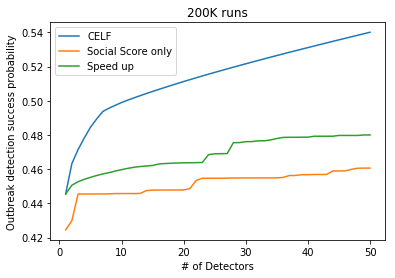

In [68]:
plt.plot(range(1, 51), celf_outbreakP_point001_point3, label="CELF")
plt.plot(range(1, 51), social_outbreakP_point001_point3, label="Social Score only")
plt.plot(range(1, 51), speedup_outbreakP_point003_point3, label="Speed up")
plt.title("200K runs, P_infect = 0.3, P_initial_infect = 0.001")
plt.ylabel("Outbreak detection success probability")
plt.xlabel("# of Detectors")
plt.legend()

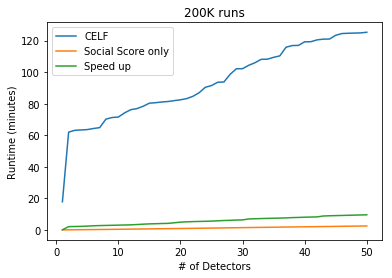

In [70]:
plt.plot(range(1,51), celf_runtimes_point001_point3, label="CELF")
plt.plot(range(1,51), social_runtimes_point001_point3, label="Social Score only")
plt.plot(range(1,51), speedup_runtimes_point001_point3 , label="Speed up")
plt.title("200K runs, P_infect = 0.3, P_initial_infect = 0.001")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

p_initial = 0.001, p_infect = 0.5

In [17]:

celf_outbreakP_point001_point5, celf_runtimes_point001_point5 = celf_outbreakP_live_edges(0.001, 0.5, live_edges_200k_point001_point5, 50 )


Running CELF to optimize detection probability w/ live edges
We have our first best node: 
[453]
Runtime (minutes) = 25.8159500003
After doing CELF, we have found the 2th detector w/ best marginal gain = 246
Outbreak detection probability so far: 0.56714
Runtime (minutes) so far = 87.2593000015
After doing CELF, we have found the 3th detector w/ best marginal gain = 1701
Outbreak detection probability so far: 0.575785
Runtime (minutes) so far = 88.7178166668
After doing CELF, we have found the 4th detector w/ best marginal gain = 1952
Outbreak detection probability so far: 0.583595
Runtime (minutes) so far = 90.7463666677
After doing CELF, we have found the 5th detector w/ best marginal gain = 547
Outbreak detection probability so far: 0.59009
Runtime (minutes) so far = 91.4904500008
After doing CELF, we have found the 6th detector w/ best marginal gain = 1377
Outbreak detection probability so far: 0.59589
Runtime (minutes) so far = 92.2316500028
After doing CELF, we have found the 7th

In [12]:
social_outbreakP_point001_point5, social_runtimes_point001_point5 = run_social_score(0.001, 0.5, live_edges_200k_point001_point5, 50 )

After doing Social Score, we have found the 1th detector = 1874
Outbreak detection probability so far: 0.53576
Marginal gain = 0.53576
Runtime (minutes) = 0.061266664664
After doing Social Score, we have found the 2th detector = 1258
Outbreak detection probability so far: 0.539245
Marginal gain = 0.003485
Runtime (minutes) = 0.125933333238
After doing Social Score, we have found the 3th detector = 1669
Outbreak detection probability so far: 0.544755
Marginal gain = 0.00551
Runtime (minutes) = 0.193333331744
After doing Social Score, we have found the 4th detector = 999
Outbreak detection probability so far: 0.544755
Marginal gain = 0.0
Runtime (minutes) = 0.257133332888
After doing Social Score, we have found the 5th detector = 511
Outbreak detection probability so far: 0.544755
Marginal gain = 0.0
Runtime (minutes) = 0.321416668097
After doing Social Score, we have found the 6th detector = 852
Outbreak detection probability so far: 0.544755
Marginal gain = 0.0
Runtime (minutes) = 0.38

After doing Social Score, we have found the 50th detector = 350
Outbreak detection probability so far: 0.55759
Marginal gain = 0.0
Runtime (minutes) = 3.32713333368


In [9]:
speedup_outbreakP_point001_point5, speedup_runtimes_point001_point5 = speedup_outbreakP_live_edges(0.001, 0.5, live_edges_200k_point001_point5, 50, "socialScore_modified_unpruned.txt")

Running CELF w/ social score speed ups to optimize detection probability w/ live edges
We have our first best node: 
[453]
Runtime (minutes) = 0.218233331045
After doing speed up, we have found the 2th detector w/ best marginal gain = 1144
Outbreak detection probability so far: 0.548865
Runtime (minutes) so far = 2.96329999765
After doing speed up, we have found the 3th detector w/ best marginal gain = 278
Outbreak detection probability so far: 0.551165
Runtime (minutes) so far = 3.08876666625
After doing speed up, we have found the 4th detector w/ best marginal gain = 984
Outbreak detection probability so far: 0.55234
Runtime (minutes) so far = 3.21126666466
After doing speed up, we have found the 5th detector w/ best marginal gain = 1287
Outbreak detection probability so far: 0.553495
Runtime (minutes) so far = 3.45784999927
After doing speed up, we have found the 6th detector w/ best marginal gain = 1874
Outbreak detection probability so far: 0.55464
Runtime (minutes) so far = 3.581

After doing speed up, we have found the 50th detector w/ best marginal gain = 656
Outbreak detection probability so far: 0.576075
Runtime (minutes) so far = 11.3118666649


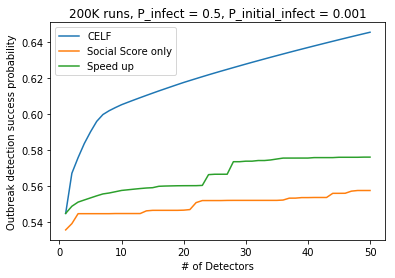

In [21]:
plt.plot(range(1, 51), celf_outbreakP_point001_point5, label="CELF")
plt.plot(range(1, 51), social_outbreakP_point001_point5, label="Social Score only")
plt.plot(range(1, 51), speedup_outbreakP_point001_point5, label="Speed up")
plt.title("200K runs, P_infect = 0.5, P_initial_infect = 0.001")
plt.ylabel("Outbreak detection success probability")
plt.xlabel("# of Detectors")
plt.legend()

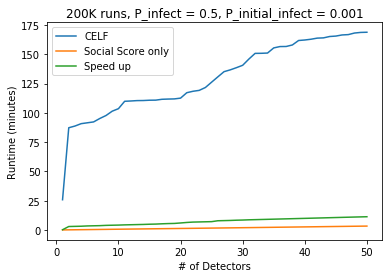

In [22]:
plt.plot(range(1,51), celf_runtimes_point001_point5, label="CELF")
plt.plot(range(1,51), social_runtimes_point001_point5, label="Social Score only")
plt.plot(range(1,51), speedup_runtimes_point001_point5, label="Speed up")
plt.title("200K runs, P_infect = 0.5, P_initial_infect = 0.001")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

p_initial = 0.005, p_infect = 0.3, runtime comparisons being done here

In [8]:
celf_outbreakP_point005_point3, celf_runtimes_point005_point3 = celf_outbreakP_live_edges(0.005, 0.3, live_edges_200k_point005_point3[:10000], 50 )


Running CELF to optimize detection probability w/ live edges
We have our first best node: 
[453]
Runtime (minutes) = 2.30176666578
After doing CELF, we have found the 2th detector w/ best marginal gain = 246
Outbreak detection probability so far: 0.9578
Runtime (minutes) so far = 7.03989999692
After doing CELF, we have found the 3th detector w/ best marginal gain = 1952
Outbreak detection probability so far: 0.9615
Runtime (minutes) so far = 9.70361666679
After doing CELF, we have found the 4th detector w/ best marginal gain = 1701
Outbreak detection probability so far: 0.9641
Runtime (minutes) so far = 9.85379999876
After doing CELF, we have found the 5th detector w/ best marginal gain = 547
Outbreak detection probability so far: 0.9661
Runtime (minutes) so far = 9.86491666635
After doing CELF, we have found the 6th detector w/ best marginal gain = 1144
Outbreak detection probability so far: 0.9677
Runtime (minutes) so far = 9.8762166659
After doing CELF, we have found the 7th detecto

In [7]:
speedup_outbreakP_point005_point3, speedup_runtimes_point005_point3 = speedup_outbreakP_live_edges(0.005, 0.3, live_edges_200k_point005_point3[:100000], 50, "socialScore_modified_unpruned.txt")

Running CELF w/ social score speed ups to optimize detection probability w/ live edges
We have our first best node: 
[453]
Runtime (minutes) = 0.144166668256
After doing speed up, we have found the 2th detector w/ best marginal gain = 1144
Outbreak detection probability so far: 0.9493
Runtime (minutes) so far = 1.83859999975
After doing speed up, we have found the 3th detector w/ best marginal gain = 278
Outbreak detection probability so far: 0.95025
Runtime (minutes) so far = 1.91076666911
After doing speed up, we have found the 4th detector w/ best marginal gain = 1874
Outbreak detection probability so far: 0.9508
Runtime (minutes) so far = 2.09155000051
After doing speed up, we have found the 5th detector w/ best marginal gain = 480
Outbreak detection probability so far: 0.95134
Runtime (minutes) so far = 2.1638166666
After doing speed up, we have found the 6th detector w/ best marginal gain = 1287
Outbreak detection probability so far: 0.95183
Runtime (minutes) so far = 2.235633333

After doing speed up, we have found the 50th detector w/ best marginal gain = 656
Outbreak detection probability so far: 0.96156
Runtime (minutes) so far = 7.33433333635


In [6]:
social_outbreakP_point005_point3, social_runtimes_point005_point3 = run_social_score(0.005, 0.3, live_edges_200k_point005_point3[:100000], 50 )

After doing Social Score, we have found the 1th detector = 1874
Outbreak detection probability so far: 0.9355
Marginal gain = 0.9355
Runtime (minutes) = 0.0353333353996
After doing Social Score, we have found the 2th detector = 1258
Outbreak detection probability so far: 0.93837
Marginal gain = 0.00287
Runtime (minutes) = 0.0722500006358
After doing Social Score, we have found the 3th detector = 1669
Outbreak detection probability so far: 0.9469
Marginal gain = 0.00853
Runtime (minutes) = 0.108933333556
After doing Social Score, we have found the 4th detector = 999
Outbreak detection probability so far: 0.9469
Marginal gain = 0.0
Runtime (minutes) = 0.144799999396
After doing Social Score, we have found the 5th detector = 511
Outbreak detection probability so far: 0.94692
Marginal gain = 2e-05
Runtime (minutes) = 0.181216665109
After doing Social Score, we have found the 6th detector = 852
Outbreak detection probability so far: 0.94692
Marginal gain = 0.0
Runtime (minutes) = 0.21711666

After doing Social Score, we have found the 50th detector = 350
Outbreak detection probability so far: 0.95366
Marginal gain = 0.0
Runtime (minutes) = 1.96485000054


In [12]:
speedup_outbreakP_point005_point3

[0.9469,
 0.9493,
 0.95025,
 0.9508,
 0.95134,
 0.95183,
 0.9522,
 0.95249,
 0.95284,
 0.9533,
 0.95354,
 0.95378,
 0.95397,
 0.95414,
 0.95429,
 0.9547,
 0.95478,
 0.95485,
 0.95491,
 0.95497,
 0.95502,
 0.95505,
 0.9551,
 0.95699,
 0.95721,
 0.95723,
 0.95725,
 0.95982,
 0.95983,
 0.96007,
 0.96008,
 0.96039,
 0.9604,
 0.96058,
 0.96084,
 0.96111,
 0.96114,
 0.96114,
 0.96116,
 0.96116,
 0.96139,
 0.96139,
 0.96139,
 0.96139,
 0.96152,
 0.96152,
 0.96152,
 0.96152,
 0.96156,
 0.96156]

In [9]:
celf_10k_runtimes = celf_runtimes_point005_point3

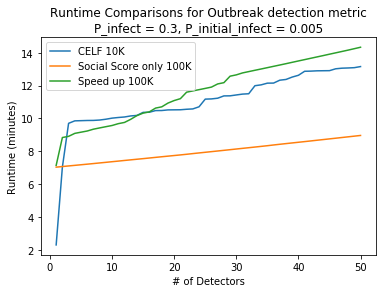

In [15]:
plt.plot(range(1,51), celf_10k_runtimes, label="CELF 10K")
plt.plot(range(1,51), [runtime + 7 for runtime in social_runtimes_point005_point3], label="Social Score only 100K")
plt.plot(range(1,51), [runtime + 7 for runtime in speedup_runtimes_point005_point3], label="Speed up 100K")
plt.title("Runtime Comparisons for Outbreak detection metric\nP_infect = 0.3, P_initial_infect = 0.005")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

p_initial = 0.005, p_infect = 0.5

In [ ]:
celf_outbreakP_point005_point5, celf_runtimes_point005_point5 = celf_outbreakP_live_edges(0.005, 0.5, live_edges_200k_point005_point5[:10000], 20 )


Running CELF to optimize detection probability w/ live edges
We have our first best node: 
[453]
Runtime (minutes) = 2.96911666393


In [ ]:
speedup_outbreakP_point005_point5, speedup_runtimes_point005_point5 = speedup_outbreakP_live_edges(0.005, 0.5, live_edges_200k_point005_point5[:10000], 20, "socialScore_modified_unpruned.txt")

In [ ]:
social_outbreakP_point005_point5, social_runtimes_point005_point5 = run_social_score(0.005, 0.5, live_edges_200k_point005_point5[:10000], 20 )

In [ ]:
plt.plot(range(1, 51), celf_outbreakP_point005_point5, label="CELF")
plt.plot(range(1, 51), social_outbreakP_point005_point5, label="Social Score only")
plt.plot(range(1, 51), speedup_outbreakP_point005_point5, label="Speed up")
plt.title("200K runs, P_infect = 0.5, P_initial_infect = 0.005")
plt.ylabel("Outbreak detection success probability")
plt.xlabel("# of Detectors")
plt.legend()

In [ ]:
plt.plot(range(1,51), celf_runtimes_point005_point5, label="CELF")
plt.plot(range(1,51), social_runtimes_point005_point5, label="Social Score only")
plt.plot(range(1,51), speedup_runtimes_point005_point5, label="Speed up")
plt.title("200K runs, P_infect = 0.5, P_initial_infect = 0.005")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

# Save CELF Runs

In [26]:
pickle.dump(celf_outbreakP_point001_point5, open("celf_outbreakP_point001_point5", "wb"))
pickle.dump(celf_runtimes_point001_point5, open("celf_outbreakP_runtimes_point001point5", "wb"))
pickle.dump(celf_outbreakP_point005_point3, open("celf_outbreakP_point005_point3", "wb"))
pickle.dump(celf_runtimes_point005_point3, open("celf_outbreakP_runtimes_point005point3", "wb"))

In [ ]:
pickle.dump(celf_outbreakP_point005_point5, open("celf_outbreakP_point005_point5", "wb"))
pickle.dump(celf_runtimes_point005_point5, open("celf_outbreakP_runtimes_point005point5" "wb"))
pickle.dump(celf_outbreakP_point001_point3, open("celf_outbreakP_point001_point3", "wb"))
pickle.dump(celf_runtimes_point001_point3, open("celf_outbreakP_runtimes_point001point3" "wb"))